In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#### Open the 2018 andn 2015 datasets for the NASA 1km derived 100-year RP output

In [2]:
ds = xr.open_mfdataset(["data/GFM_global_NASA1km_2018slr_rp0100.nc", "data/GFM_global_NASA1km_2050slr_rp0100.nc"], 
                         combine="nested", concat_dim="time")

# Fix the coordinate lables per file
ds = ds.assign_coords(time=np.array([np.datetime64("2018-01-01"), np.datetime64("2050-01-01")]))
ds

<xarray.Dataset>
Dimensions:     (lat: 15660, lon: 38880, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2018-01-01 2050-01-01
  * lat         (lat) float64 -60.0 -59.99 -59.98 -59.97 ... 84.98 84.99 84.99
  * lon         (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    projection  (time) |S1 b'' b''
    inun        (time, lat, lon) float32 dask.array<chunksize=(1, 15660, 38880), meta=np.ndarray>
Attributes:
    source:       Global Tide and Surge Model v3.0 - ERA5
    institution:  Deltares
    title:        GFM - NASA 1km - 2018 slr - 0100-year return level
    references:   https://www.deltares.nl/en/
    Conventions:  CF-1.6
    project:      Microsoft Planetary Computer - Global Flood Maps
    config_file:  /p/temp/global/NASA1km_newWaterMask_noData/run_rp0100_slr20...
    history:      Created by: $Id: coastal_inun.py 528 2018-06-19 08:41:05Z e...

#### Define some bounding boxes for at-risk coastal areas 

In [3]:
from shapely.geometry import shape

nola_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [-91.730, 29.123],
            [-89.296, 29.123],
            [-89.296, 30.045],
            [-91.730, 30.045],
            [-91.730, 29.123]
          ]
        ]
    }

sfl_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.11181640625, 24.467150664739002],
            [-79.69482421875, 24.467150664739002],
            [-79.69482421875, 26.31311263768267],
            [-82.11181640625, 26.31311263768267],
            [-82.11181640625, 24.467150664739002]
          ]
        ]
      }

sfl_geojson_1 = {
        "type": "Polygon",
        "coordinates": [
          [
            [-82.2271728515625,25.854280326572407],
            [-81.1834716796875,25.854280326572407],
            [-81.1834716796875,26.534479888888043],
            [-82.2271728515625,26.534479888888043],
            [-82.2271728515625,25.854280326572407]
          ]
        ]
      }

myanmar_geojson = {
        "type": "Polygon",
        "coordinates": [
          [
            [92.74658203125,18.542116654448996],
            [94.68017578125,18.542116654448996],
            [94.68017578125,20.406420474920292],
            [92.74658203125,20.406420474920292],
            [92.74658203125,18.542116654448996]
          ]
        ]
      }

png_geojson = {"type":"Polygon","coordinates":[[[137.3291015625,-9.838979375579331],[144.55810546875,-9.838979375579331],[144.55810546875,-4.653079918274038],[137.3291015625,-4.653079918274038],[137.3291015625,-9.838979375579331]]]}

poly = shape(myanmar_geojson)
minx, miny, maxx, maxy = poly.bounds

#### Crop the array to a specified geo-area
- TODO: Support non-bbox polygon, rasterize a vector and do a mask?

In [4]:
ds = ds.sel(lat=slice(miny, maxy), lon=slice(minx, maxx))

In [5]:
# Validation check compare mean inun each year
print(ds["inun"].sel(time="2018-01-01").mean().values)
print(ds["inun"].sel(time="2050-01-01").mean().values)


0.22406109
0.6118866


#### Visualize the coastal inundation

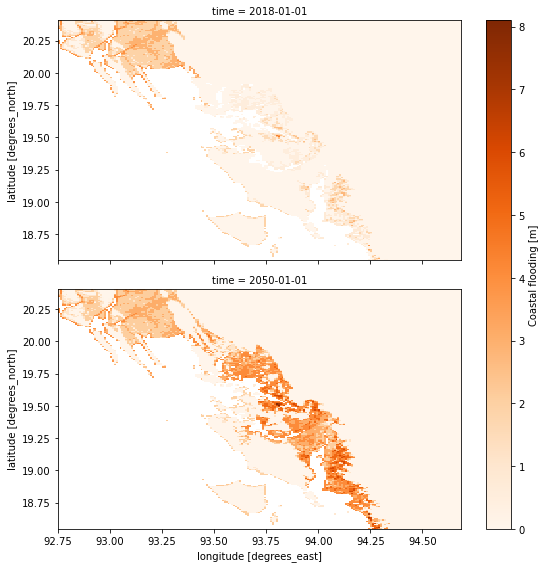

In [6]:
ds.inun.plot(col="time", col_wrap=1, figsize=(8,8), cmap="Oranges")

#### Distribution of inundation amount

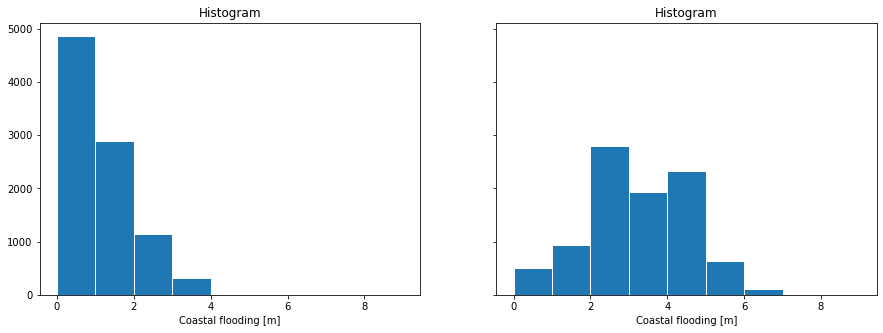

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True, sharex=True)

# Can't set title?
axes[0].title.set_text("2018 100yr return")
axes[1].set_title("2050 100yr return")

# Faceted plot doesn't seem to work for hist()
for i in range(2):
    ds.inun.isel(time=i).where(ds.inun > 0).plot.hist(ax=axes[i], edgecolor="white", bins=range(0,10))

plt.show()

In [8]:
ds.inun

<xarray.DataArray 'inun' (time: 2, lat: 201, lon: 209)>
dask.array<getitem, shape=(2, 201, 209), dtype=float32, chunksize=(1, 201, 209), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2050-01-01
  * lat      (lat) float64 18.55 18.56 18.57 18.58 ... 20.37 20.38 20.39 20.4
  * lon      (lon) float64 92.75 92.76 92.77 92.78 ... 94.65 94.66 94.67 94.68
Attributes:
    units:          m
    standard_name:  water_surface_height_above_reference_datum
    long_name:      Coastal flooding
    comment:        water_surface_reference_datum_altitude is given in file /...

#### Select only inundated area


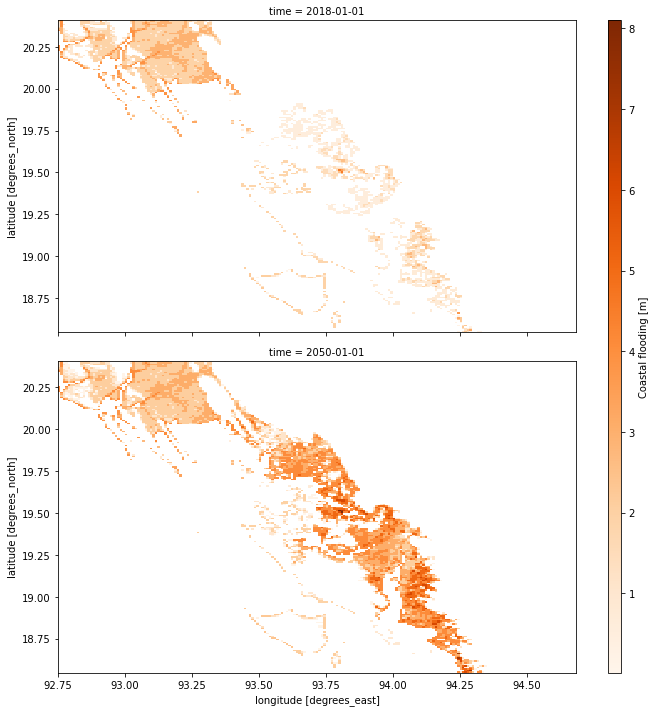

In [9]:
flooded = ds.where(ds.inun > 0)
flooded.inun.plot(col="time", col_wrap=1, figsize=(10, 10), 
                  cmap="Oranges", cbar_kwargs={"aspect": 50})

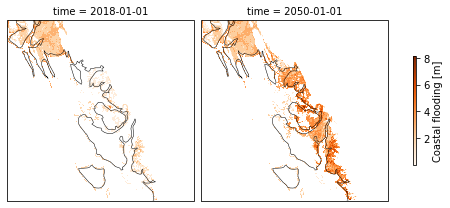

In [10]:
import cartopy.crs as ccrs

prj = ccrs.PlateCarree()

# Too small? https://github.com/pydata/xarray/issues/1397
# https://stackoverflow.com/questions/67265487/xarray-facetgrid-map-with-cartopy-produces-unusable-plot-with-certain-dataset-p
p = flooded.inun.plot(
    col="time",
    col_wrap=None,
    transform=prj,
    subplot_kws={"projection":prj},
    cmap="Oranges",
    cbar_kwargs={"aspect": 30, "shrink": 0.6}
)

for ax in p.axes.flat:
    ax.coastlines(linewidth=0.5)
    ax.set_extent([minx, maxx, miny, maxy])

plt.draw()

#### Plot predicted rise > 1m by 2050

In [11]:
a = ds["inun"].sel(time="2018-01-01")
b = ds["inun"].sel(time="2050-01-01")

diff = (b - a)
diff = diff.where(diff > 1, np.nan)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


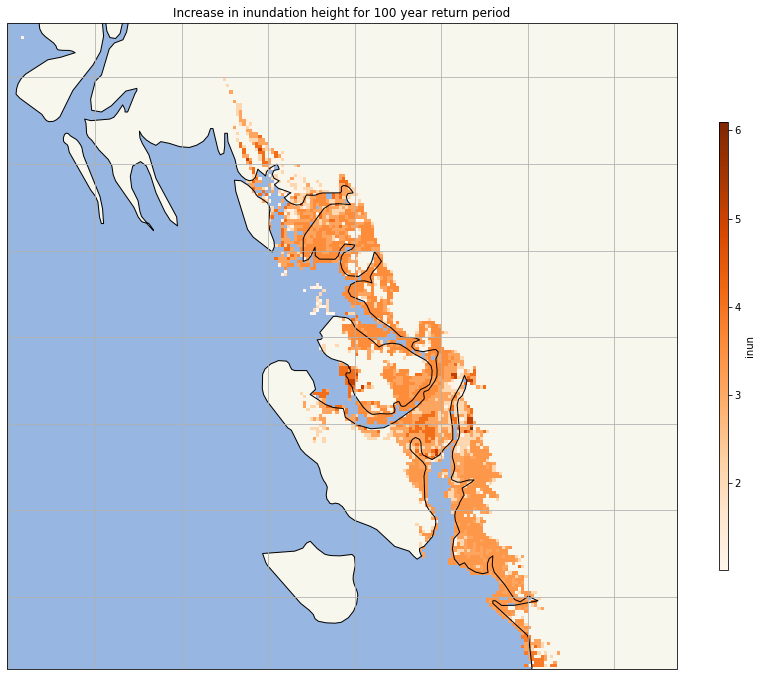

In [14]:
import cartopy.feature as cfeature

fig, axis = plt.subplots(
    1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()),
    figsize=(15,15)
)

diff.plot(
    ax=axis,
    transform=ccrs.PlateCarree(),
    cmap="Oranges",
    cbar_kwargs={"aspect": 50, "shrink": 0.55}
)
plt.title("Increase in inundation height for 100 year return period")
axis.coastlines(color="black", linewidth=1)
axis.gridlines()
axis.set_extent([minx, maxx, miny, maxy])

axis.add_feature(cfeature.OCEAN, zorder=0)
axis.add_feature(cfeature.LAND, zorder=0, linewidth=0, facecolor="#f7f7ed")

plt.draw()